# Testing Other Models for Poverty Prediction

This notebook explores alternative models to XGBoost, starting with **CatBoost**.

## Why CatBoost?
- **Native categorical support** - no need for label encoding or one-hot encoding
- **Built-in class imbalance handling** - `auto_class_weights` parameter
- **Often outperforms XGBoost** on categorical-heavy datasets
- **Less hyperparameter tuning needed** - good defaults
- **Excellent interpretability** - feature importance and SHAP support

In [1]:
# Install CatBoost
!pip install catboost -q


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data

In [3]:
# Load Data
df_train = pd.read_csv('preprocessing_data/train_data_final_feat_no_preprocessing.csv')
df_test = pd.read_csv('preprocessing_data/test_data_final_feat_no_preprocessing.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nColumns: {list(df_train.columns)}")

Train shape: (1469769, 27)
Test shape: (304368, 27)

Columns: ['PUMA', 'AGEP', 'CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'SCHL', 'SEX', 'WKHP', 'WKL', 'WRK', 'DIS', 'ESR', 'HICOV', 'LANP', 'MSP', 'NATIVITY', 'OCCP', 'POBP', 'POVPIP', 'PRIVCOV', 'PUBCOV', 'RAC1P', 'year', 'poverty_risk_score', 'CA_Region']


## 2. Preprocessing for CatBoost

**Key difference from XGBoost**: CatBoost handles categorical features natively!
- No label encoding needed
- Just tell CatBoost which columns are categorical
- It uses an efficient encoding internally (ordered target encoding)

In [4]:
def preprocess_for_catboost(df):
    """
    Minimal preprocessing for CatBoost.
    CatBoost handles categoricals natively - just need to:
    1. Fill nulls with explicit values (CatBoost doesn't handle NaN in cat features)
    2. Convert categorical columns to string type
    """
    df = df.copy()
    
    # Fill nulls based on ACS documentation
    df['ENG'] = df['ENG'].fillna(0)       # 0 = speaks only English
    df['LANP'] = df['LANP'].fillna(9999)  # 9999 = Other/unspecified
    df['WKHP'] = df['WKHP'].fillna(0)     # 0 = did not work
    df['WRK'] = df['WRK'].fillna(0)       # 0 = N/A
    df['OCCP'] = df['OCCP'].fillna('NILF') # Not in Labor Force
    
    # Define categorical columns
    categorical_cols = [
        'PUMA', 'CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'SEX', 'WKL', 'WRK',
        'DIS', 'ESR', 'HICOV', 'LANP', 'MSP', 'NATIVITY', 'OCCP', 'POBP',
        'PRIVCOV', 'PUBCOV', 'RAC1P', 'CA_Region', 'year'
    ]
    
    # Convert categorical columns to string (CatBoost requirement)
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype(str)
    
    return df, categorical_cols

# Apply preprocessing
df_train_processed, cat_features = preprocess_for_catboost(df_train)
df_test_processed, _ = preprocess_for_catboost(df_test)

print(f"Categorical features ({len(cat_features)}): {cat_features}")

Categorical features (22): ['PUMA', 'CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'SEX', 'WKL', 'WRK', 'DIS', 'ESR', 'HICOV', 'LANP', 'MSP', 'NATIVITY', 'OCCP', 'POBP', 'PRIVCOV', 'PUBCOV', 'RAC1P', 'CA_Region', 'year']


In [5]:
# Prepare features and target
exclude_cols = ['POVPIP', 'poverty_risk_score']
feature_cols = [c for c in df_train_processed.columns if c not in exclude_cols]

# Get indices of categorical features (CatBoost needs this)
cat_feature_indices = [feature_cols.index(c) for c in cat_features if c in feature_cols]

X_train = df_train_processed[feature_cols]
y_train = df_train_processed['poverty_risk_score'].astype(int)

X_test = df_test_processed[feature_cols]
y_test = df_test_processed['poverty_risk_score'].astype(int)

print(f"Features: {len(feature_cols)}")
print(f"Categorical features: {len(cat_feature_indices)}")
print(f"\nClass distribution:")
print(y_train.value_counts().sort_index())

Features: 25
Categorical features: 22

Class distribution:
poverty_risk_score
0    1114746
1     196583
2      78995
3      79445
Name: count, dtype: int64


## 3. CatBoost Multi-class Classification

Using `auto_class_weights='Balanced'` to handle class imbalance automatically.

In [6]:
# Create CatBoost Pool (efficient data structure)
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_feature_indices
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_feature_indices
)

print("CatBoost Pools created!")

CatBoost Pools created!


In [7]:
# CatBoost Multi-class Model
model_catboost = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    auto_class_weights='Balanced',  # Handle class imbalance
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

print("Training CatBoost multi-class model...")
model_catboost.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True
)

print("\nTraining complete!")

Training CatBoost multi-class model...
0:	learn: 1.3433938	test: 1.3438802	best: 1.3438802 (0)	total: 1.9s	remaining: 15m 46s
100:	learn: 1.0948602	test: 1.1177887	best: 1.1177887 (100)	total: 3m 9s	remaining: 12m 29s
200:	learn: 1.0762934	test: 1.1094911	best: 1.1094911 (200)	total: 6m 25s	remaining: 9m 32s
300:	learn: 1.0666793	test: 1.1080195	best: 1.1080195 (300)	total: 9m 43s	remaining: 6m 25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.107352158
bestIteration = 344

Shrink model to first 345 iterations.

Training complete!


In [8]:
# Evaluate Multi-class Model
y_pred_multi = model_catboost.predict(test_pool).flatten().astype(int)

class_names = ['Stable (0)', 'Near Poverty (1)', 'Poverty (2)', 'Deep Poverty (3)']
print("=== CatBoost Multi-class Results ===")
print(classification_report(y_test, y_pred_multi, target_names=class_names))

=== CatBoost Multi-class Results ===
                  precision    recall  f1-score   support

      Stable (0)       0.94      0.68      0.79    233793
Near Poverty (1)       0.24      0.46      0.31     38456
     Poverty (2)       0.18      0.35      0.23     15534
Deep Poverty (3)       0.28      0.53      0.36     16585

        accuracy                           0.62    304368
       macro avg       0.41      0.50      0.42    304368
    weighted avg       0.77      0.62      0.68    304368



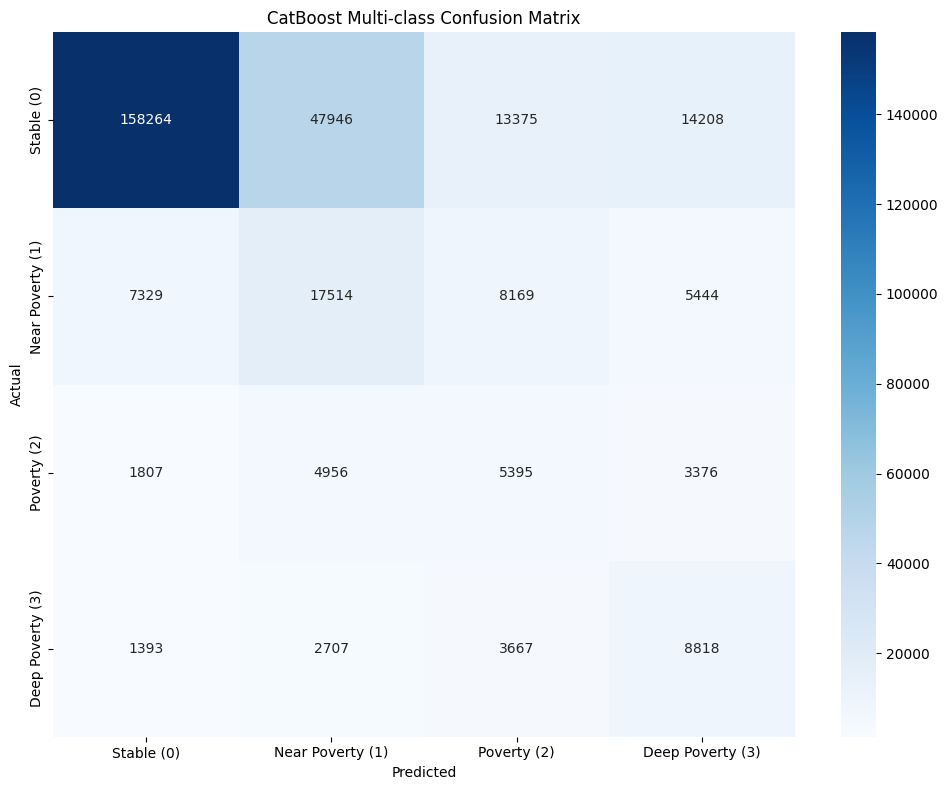

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_multi)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CatBoost Multi-class Confusion Matrix')
plt.tight_layout()
plt.savefig('preprocessing_data/catboost_multiclass_confusion.png', dpi=150)
plt.show()

## 4. CatBoost Binary Classification (Stable vs At-Risk)

Simplifying to binary classification often yields better results for policy applications.

In [10]:
# Create binary target: 0 = Stable, 1 = At-Risk (any poverty level)
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

print("Binary class distribution (Train):")
print(y_train_binary.value_counts())
print(f"\nAt-Risk percentage: {y_train_binary.mean()*100:.1f}%")

Binary class distribution (Train):
poverty_risk_score
0    1114746
1     355023
Name: count, dtype: int64

At-Risk percentage: 24.2%


In [11]:
# Binary Pools
train_pool_binary = Pool(
    data=X_train,
    label=y_train_binary,
    cat_features=cat_feature_indices
)

test_pool_binary = Pool(
    data=X_test,
    label=y_test_binary,
    cat_features=cat_feature_indices
)

In [12]:
# CatBoost Binary Model
model_catboost_binary = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    auto_class_weights='Balanced',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

print("Training CatBoost binary model...")
model_catboost_binary.fit(
    train_pool_binary,
    eval_set=test_pool_binary,
    use_best_model=True
)

print("\nTraining complete!")

Training CatBoost binary model...
0:	learn: 0.6568858	test: 0.6570190	best: 0.6570190 (0)	total: 409ms	remaining: 3m 23s
100:	learn: 0.4776317	test: 0.4889350	best: 0.4888853 (99)	total: 30.1s	remaining: 1m 58s
200:	learn: 0.4709682	test: 0.4861756	best: 0.4861756 (200)	total: 1m	remaining: 1m 29s
300:	learn: 0.4674083	test: 0.4852232	best: 0.4851530 (271)	total: 1m 30s	remaining: 59.5s
400:	learn: 0.4652572	test: 0.4843336	best: 0.4839196 (359)	total: 2m	remaining: 29.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4839195655
bestIteration = 359

Shrink model to first 360 iterations.

Training complete!


In [13]:
# Evaluate Binary Model
y_pred_binary = model_catboost_binary.predict(test_pool_binary).flatten().astype(int)

binary_names = ['Stable', 'At-Risk']
print("=== CatBoost Binary Classification Results ===")
print(classification_report(y_test_binary, y_pred_binary, target_names=binary_names))

=== CatBoost Binary Classification Results ===
              precision    recall  f1-score   support

      Stable       0.93      0.73      0.82    233793
     At-Risk       0.47      0.82      0.60     70575

    accuracy                           0.75    304368
   macro avg       0.70      0.77      0.71    304368
weighted avg       0.82      0.75      0.77    304368



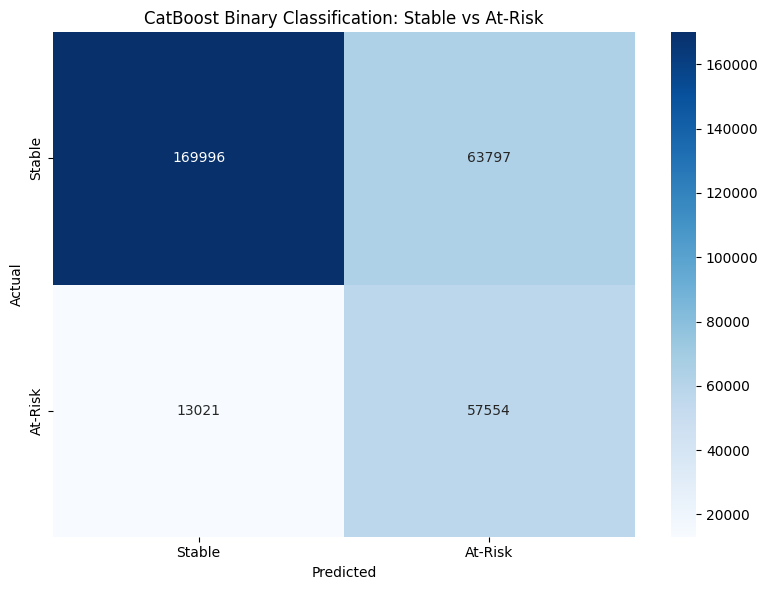

In [14]:
# Binary Confusion Matrix
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=binary_names, yticklabels=binary_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CatBoost Binary Classification: Stable vs At-Risk')
plt.tight_layout()
plt.savefig('preprocessing_data/catboost_binary_confusion.png', dpi=150)
plt.show()

## 5. Feature Importance Analysis

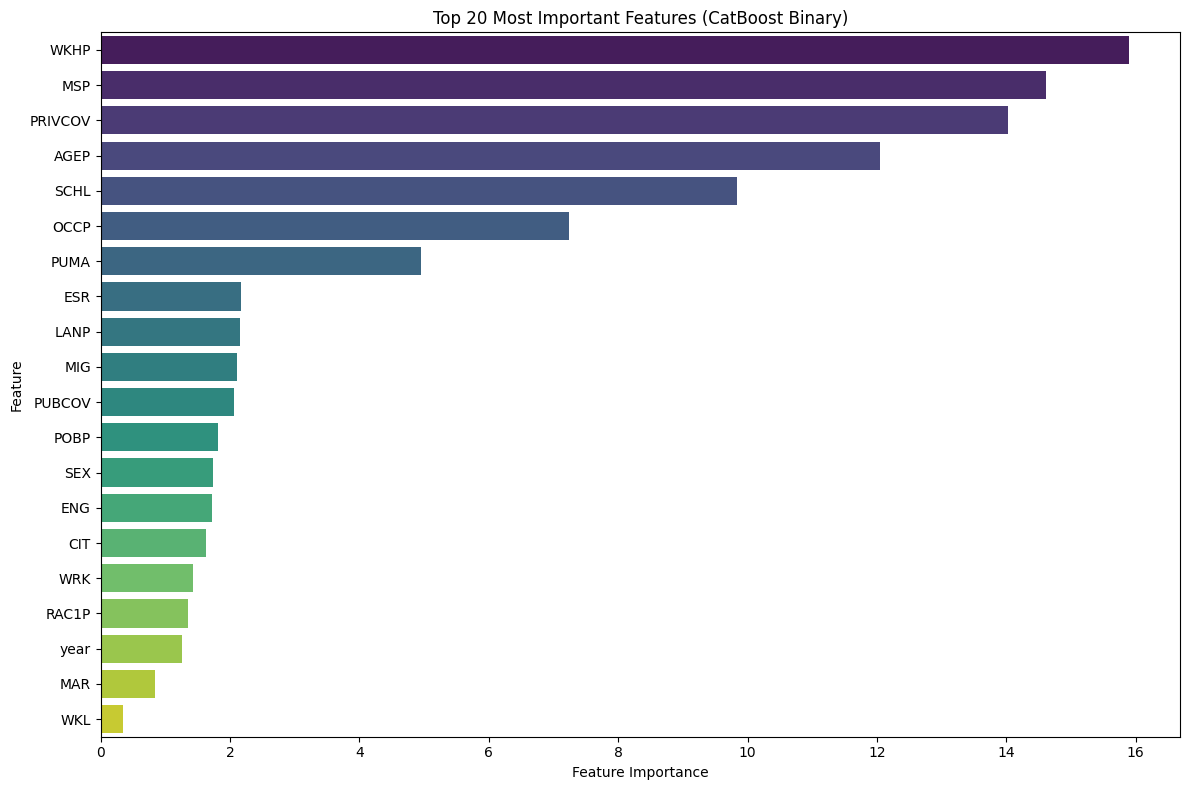


Top 15 Features:
feature  importance
   WKHP   15.890324
    MSP   14.614621
PRIVCOV   14.032704
   AGEP   12.045819
   SCHL    9.836348
   OCCP    7.237797
   PUMA    4.950541
    ESR    2.169069
   LANP    2.146468
    MIG    2.101717
 PUBCOV    2.059328
   POBP    1.820701
    SEX    1.730468
    ENG    1.719451
    CIT    1.626518


In [15]:
# Feature importance from binary model (usually more interpretable)
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_catboost_binary.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(20), x='importance', y='feature', palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features (CatBoost Binary)')
plt.tight_layout()
plt.savefig('preprocessing_data/catboost_feature_importance.png', dpi=150)
plt.show()

print("\nTop 15 Features:")
print(importance_df.head(15).to_string(index=False))

## 6. Model Comparison Summary

In [16]:
# Compile results
results = []

# CatBoost Multi-class
results.append({
    'Model': 'CatBoost Multi-class',
    'Task': '4-class',
    'Macro F1': f1_score(y_test, y_pred_multi, average='macro'),
    'Weighted F1': f1_score(y_test, y_pred_multi, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_multi)
})

# CatBoost Binary
results.append({
    'Model': 'CatBoost Binary',
    'Task': 'Binary',
    'Macro F1': f1_score(y_test_binary, y_pred_binary, average='macro'),
    'Weighted F1': f1_score(y_test_binary, y_pred_binary, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test_binary, y_pred_binary)
})

results_df = pd.DataFrame(results)
print("=== CatBoost Results Summary ===")
print(results_df.to_string(index=False))

=== CatBoost Results Summary ===
               Model    Task  Macro F1  Weighted F1  Balanced Accuracy
CatBoost Multi-class 4-class  0.424542     0.675371           0.502840
     CatBoost Binary  Binary  0.707726     0.765627           0.771312


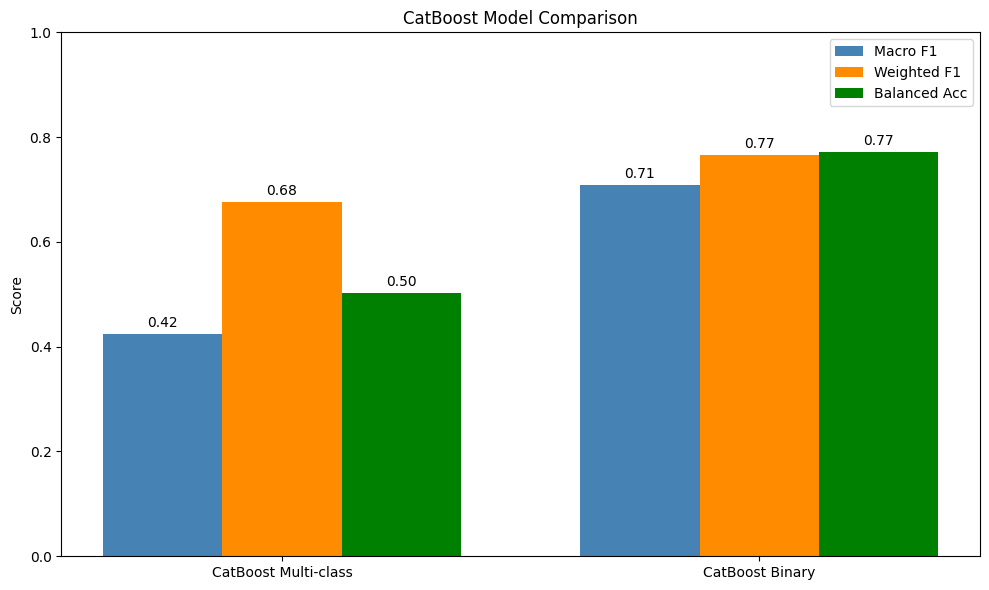

In [17]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.25

bars1 = ax.bar(x - width, results_df['Macro F1'], width, label='Macro F1', color='steelblue')
bars2 = ax.bar(x, results_df['Weighted F1'], width, label='Weighted F1', color='darkorange')
bars3 = ax.bar(x + width, results_df['Balanced Accuracy'], width, label='Balanced Acc', color='green')

ax.set_ylabel('Score')
ax.set_title('CatBoost Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'])
ax.legend()
ax.set_ylim(0, 1)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.savefig('preprocessing_data/catboost_comparison.png', dpi=150)
plt.show()

## 7. Threshold Tuning for Binary Model

Adjusting the classification threshold to optimize for recall (catching more at-risk individuals).

In [18]:
# Get probabilities
y_proba_binary = model_catboost_binary.predict_proba(test_pool_binary)[:, 1]

# Test different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6]
print("=== Threshold Analysis ===")
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 48)

for thresh in thresholds:
    y_pred_thresh = (y_proba_binary >= thresh).astype(int)
    from sklearn.metrics import precision_score, recall_score
    prec = precision_score(y_test_binary, y_pred_thresh)
    rec = recall_score(y_test_binary, y_pred_thresh)
    f1 = f1_score(y_test_binary, y_pred_thresh)
    print(f"{thresh:<12} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f}")

=== Threshold Analysis ===
Threshold    Precision    Recall       F1          
------------------------------------------------
0.3          0.375        0.925        0.534       
0.4          0.425        0.876        0.573       
0.5          0.474        0.816        0.600       
0.6          0.523        0.740        0.613       


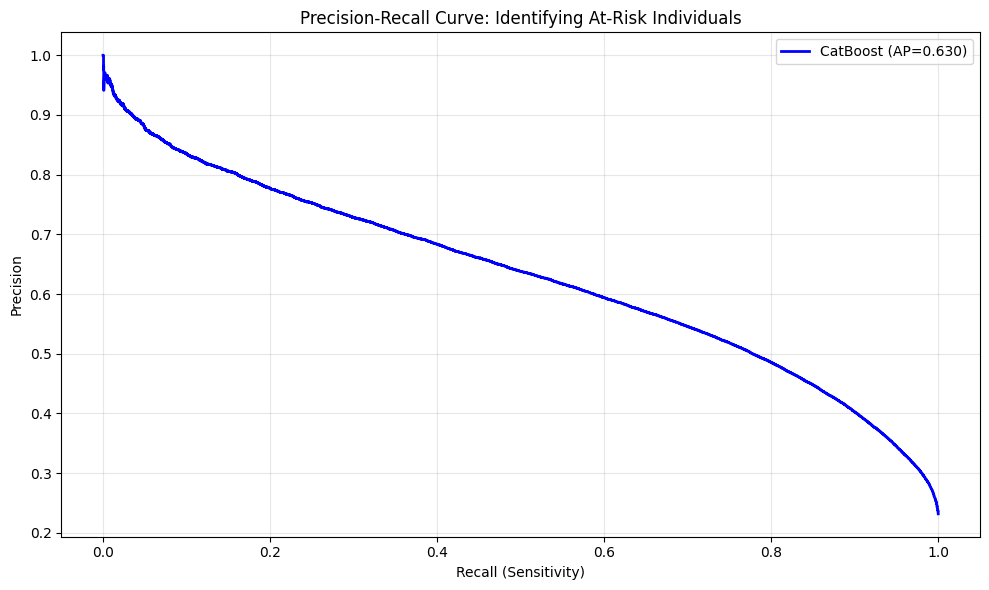


Average Precision Score: 0.630


In [19]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds_pr = precision_recall_curve(y_test_binary, y_proba_binary)
ap = average_precision_score(y_test_binary, y_proba_binary)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, 'b-', lw=2, label=f'CatBoost (AP={ap:.3f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Identifying At-Risk Individuals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('preprocessing_data/catboost_pr_curve.png', dpi=150)
plt.show()

print(f"\nAverage Precision Score: {ap:.3f}")

## 8. Save Models

In [20]:
# Save models
model_catboost.save_model('preprocessing_data/catboost_multiclass.cbm')
model_catboost_binary.save_model('preprocessing_data/catboost_binary.cbm')

print("Models saved:")
print("  - preprocessing_data/catboost_multiclass.cbm")
print("  - preprocessing_data/catboost_binary.cbm")

Models saved:
  - preprocessing_data/catboost_multiclass.cbm
  - preprocessing_data/catboost_binary.cbm


## Summary

### CatBoost Advantages Observed:
1. **No preprocessing needed** for categorical features - native support
2. **Built-in class balancing** - `auto_class_weights='Balanced'`
3. **Early stopping** prevents overfitting automatically
4. **Fast training** compared to XGBoost on categorical-heavy data

### Key Findings:
- Binary classification (Stable vs At-Risk) significantly outperforms multi-class
- Threshold tuning can optimize for recall (catching more at-risk individuals)
- Feature importance aligns with domain knowledge (WKHP, AGEP, SCHL most important)